## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import itertools
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
df = pd.read_csv('E:/PTDLKD/Đồ án/dataset/INTC.csv')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
5,2019-01-09,47.959999,48.570000,47.779999,48.009998,42.160622,22554500
6,2019-01-10,47.750000,48.650002,47.410000,48.560001,42.643612,27202600
7,2019-01-11,48.099998,49.290001,48.049999,48.930000,42.968521,21751300
8,2019-01-14,48.459999,48.830002,48.299999,48.349998,42.459190,19193900
9,2019-01-15,48.709999,49.130001,48.439999,48.599998,42.678734,22480800


## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Show Dataframe
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...
2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000


## Describe Data

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1.119000e+03
mean,48.118436,48.726944,47.526783,48.129062,44.573581,3.174412e+07
std,10.864467,10.954926,10.768599,10.864532,9.254501,1.653383e+07
min,24.730000,25.120001,24.590000,24.900000,24.309347,6.313200e+06
25%,44.185000,44.765000,43.620001,44.265000,40.537487,2.079205e+07
50%,50.240002,50.939999,49.709999,50.310001,46.126808,2.845030e+07
75%,56.055000,56.520000,55.450001,55.980002,51.632650,3.746805e+07
max,68.199997,69.290001,67.309998,68.470001,63.348759,1.822699e+08


## Visualize Data

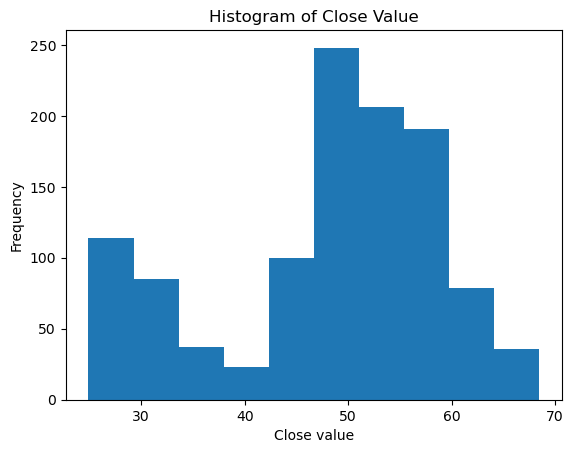

In [6]:
# Draw a histogram 
plt.hist(df['Close'])

# Set label and title
plt.xlabel('Close value')
plt.ylabel('Frequency')
plt.title('Histogram of Close Value')

# Display histogram
plt.show()

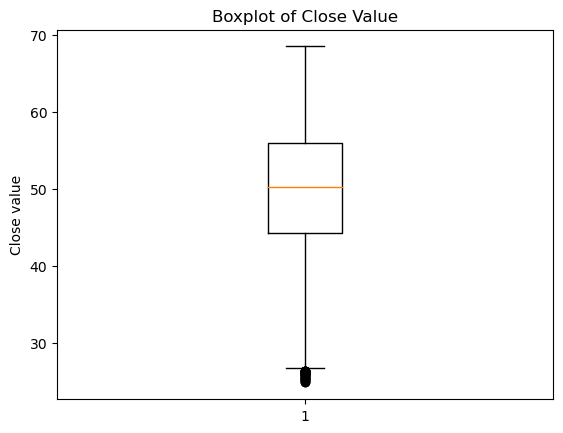

In [7]:
# Draw a boxplot
plt.boxplot(df.Close)

# Set label and title
plt.title("Boxplot of Close Value")
plt.ylabel("Close value")

# Display boxplot
plt.show()

## Split the data into train, validation and test set with a ratio of 7 : 1 : 2

In [8]:
# Define the size of train, validation, test set
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.1)
test_size = len(df) - train_size - val_size

# Split the data into train, test and validation set
train_data = df.iloc[0 : train_size, :]
val_data = df.iloc[train_size : train_size + val_size, :]
test_data = df.iloc[train_size + val_size : len(df), :]

## Extracting features

Create function augment_features to calculate the fractional change in:
1. Opening and closing prices (fracocp)
2. High prices (frachp)
3. Low prices (fraclp)

In [9]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)
    
    return new_dataframe

Function extract_features will combine the 3 calculated fractional change into 1 array

In [10]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

## Build Model

In [11]:
# Set the quantity of hidden states is 10
model = GaussianHMM(n_components=10)

In [12]:
# Extract features of train set
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)

# Training model
model.fit(features_train)

c:\Users\Admin\.conda\envs\user_env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


GaussianHMM(n_components=10)

In [13]:
# Using 50 days in the past to predict the closing price of the current day
num_latent_days = 50

# Determine the number of days will be predicted is 30 days
# num_days_to_predict = 30

## Evaluate in validation set

In [14]:
# Extract features of validation set
val_augmented = augment_features(val_data) 
val_fracocp = val_augmented['delOpenClose']
val_frachp = val_augmented['delHighOpen']
val_fraclp = val_augmented['delLowOpen']

# Divide validation set's feature values into parts
val_sample_space_fracocp = np.linspace(val_fracocp.min(), val_fracocp.max(), 50) 
val_sample_space_fraclp = np.linspace(val_fraclp.min(), val_frachp.max(), 10)
val_sample_space_frachp = np.linspace(val_frachp.min(), val_frachp.max(), 10)

# Generate the possible permutations of values for the features of validation set
possible_outcomes = np.array(list(itertools.product(val_sample_space_fracocp, val_sample_space_frachp, val_sample_space_fraclp)))

In [15]:
# best_num_step stores the number of steps in the interval that the features take
best_num_step = None

# best_mae stores the best Mean Absolute Error value
best_mae = float('inf')

In [16]:
# Experiment and find the best number of steps between 10 and 50
for num_step in np.arange(10, 50, 10):
    sample_space_fracocp = np.linspace(val_fracocp.min(), val_fracocp.max(), num_step)
    sample_space_fraclp = np.linspace(val_fraclp.min(), val_frachp.max(), int(num_step/5))
    sample_space_frachp = np.linspace(val_frachp.min(), val_frachp.max(), int(num_step/5))
    possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))
    
    predicted_close_prices = []
    
    for i in tqdm(range(val_size)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire validation data features for these days
        previous_data = extract_features(augment_features(val_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))

        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    
    # Calculate MAE value
    mae = (abs(val_data['Close'] - predicted_close_prices)).mean()

    # Compare and find the best number of steps and the best MAE value
    if mae < best_mae:
        best_num_step = num_step
        best_mae = mae

  4%|▎         | 4/111 [00:00<00:02, 37.14it/s]

100%|██████████| 111/111 [02:33<00:00,  1.38s/it]


In [17]:
# Show the best number of steps
print("The best number of steps is : ", best_num_step)

The best number of steps is :  20


## Predict model with the best number of steps

In [18]:
# Extract features of test set
test_augmented = augment_features(test_data) 
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

# Divide test set's feature values into parts
sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), best_num_step) 
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), int(best_num_step/5))
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), int(best_num_step/5))

# Generate the possible permutations of values for the features of test set
possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

In [19]:
y_pred = []

for i in tqdm(range(test_size)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Calculate start and end indices
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data)) 
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    y_pred.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0])) 

100%|██████████| 225/225 [00:46<00:00,  4.80it/s]


## Calculate the error of the model

In [20]:
# Select the test values in reality
y_act = test_data['Close']
y_act = y_act.values
y_act

array([40.610001, 39.200001, 39.16    , 38.959999, 40.18    , 39.709999,
       36.310001, 36.959999, 36.009998, 36.52    , 35.66    , 35.389999,
       35.380001, 34.52    , 35.369999, 35.59    , 36.110001, 36.34    ,
       36.189999, 35.779999, 36.200001, 35.380001, 33.84    , 33.950001,
       33.860001, 34.889999, 33.360001, 32.939999, 32.259998, 31.92    ,
       31.76    , 31.219999, 30.360001, 30.65    , 30.75    , 31.459999,
       31.559999, 29.290001, 29.18    , 28.84    , 29.24    , 29.440001,
       28.959999, 28.469999, 28.07    , 27.52    , 26.969999, 26.889999,
       27.129999, 26.379999, 25.77    , 26.969999, 27.700001, 27.639999,
       27.18    , 25.719999, 25.200001, 25.040001, 25.33    , 26.42    ,
       25.91    , 26.42    , 25.870001, 26.      , 26.08    , 26.969999,
       27.18    , 27.41    , 27.209999, 26.27    , 29.07    , 28.43    ,
       28.299999, 27.42    , 27.389999, 28.200001, 28.41    , 28.48    ,
       27.52    , 29.76    , 30.43    , 30.35    , 

In [21]:
# Select the test values in reality
test_mape = mean_absolute_percentage_error(y_act, y_pred)
test_mse = mean_squared_error(y_act, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_act, y_pred)

print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)

MAPE on Test dataset:  0.017362508153197013
RMSE on Test dataset:  0.651329385922085
MSLE on Test dataset:  0.00045078043033283986


## Model visualization

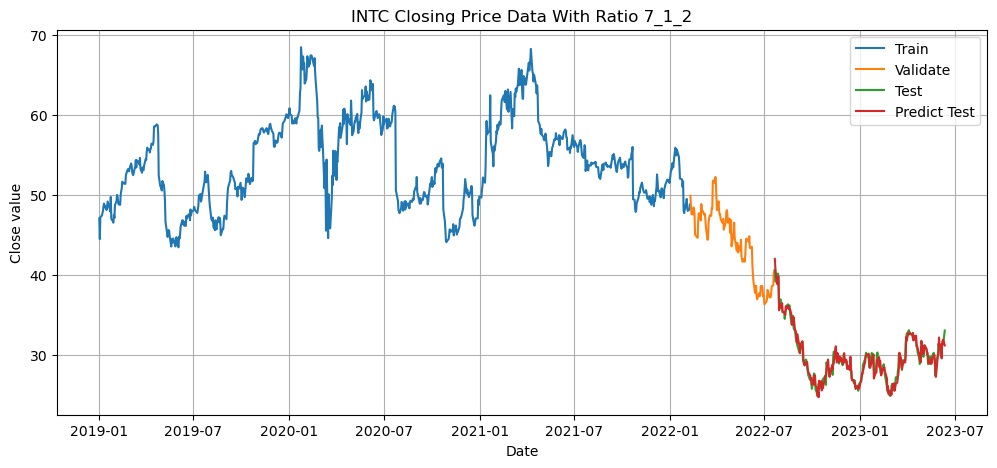

In [22]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data['Close'].values)

# Validation set
plt.plot(df[train_size : train_size + val_size].index, val_data['Close'].values)

# Test set
plt.plot(df[train_size + val_size: ].index, test_data['Close'].values)

# Predict in test set
plt.plot(df[train_size + val_size:].index, y_pred)

# Predict 30 next days
# plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict Test'])
plt.grid()
plt.title("INTC Closing Price Data With Ratio 7_1_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('HMM_712_INTC.png')
plt.show()